#### This notebook gives the mstm-wrapper results for 1 sphere, in order to compare to mie.py for debugging

In [1]:
import mstm
import matplotlib
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate
from mpl_toolkits.mplot3d import Axes3D

### First, let's calculate scattered intensity as a function of theta, for a fixed phi = 0, and compare to azimuthal average
The target has 1 sphere of radius 0.125 um, and the incident is horizontally polarized. The incident has 2pi/lamba = 15.7 ==> lambda = 0.4 um

               qext qabs    qsca
unpolarized  2.0238    0  2.0238
par          2.0238    0  2.0238
perp         2.0238    0  2.0238


<IPython.core.display.Javascript object>


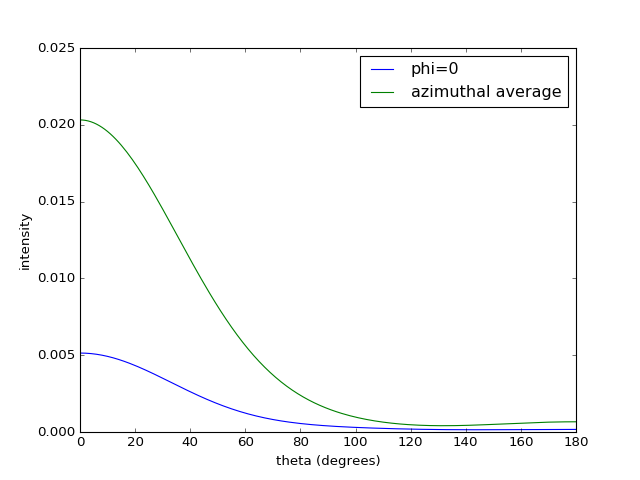

               qext qabs    qsca
unpolarized  2.0238    0  2.0238
par          2.0238    0  2.0238
perp         2.0238    0  2.0238


In [2]:
# make target object
xpos = np.array([0])
ypos = np.array([0])
zpos = np.array([0])
radii = np.array([0.125])
n_matrix = 1.0
n_spheres = 1.54
target = mstm.Target(xpos, ypos, zpos, radii, n_matrix, n_spheres)

theta = np.arange(0, 181, 1)
phi = np.array([0])
stokes_vec = np.array([1, 1, 0, 0])
wavelength = 0.4

# run MSTM and calculate the intensities
calculation = mstm.MSTMCalculation(target, wavelength, theta, phi)
result = calculation.run()
intensity = result.calc_intensity(stokes_vec)
print(result.efficiencies[0])

# plot intensity versus theta
ax = intensity[0].plot(x='theta',y='intensity', label='phi=0')

# calculate azimuthal average intensity and plot
calculation = mstm.MSTMCalculation(target, wavelength, theta, phi=None)
result = calculation.run()
intensity = result.calc_intensity(stokes_vec)
intensity[0].plot(x='theta',y='intensity', ax=ax, label='azimuthal average')
plt.xlabel('theta (degrees)')
plt.ylabel('intensity')
print(result.efficiencies[0])

### Next, let's calculate the scattered intensity as a function of theta and phi
The target has 1 sphere of radius 0.125 um, and the incident is horizontally polarized. The incident has 2pi/lamba = 15.7 ==> lambda = 0.4 um

<IPython.core.display.Javascript object>


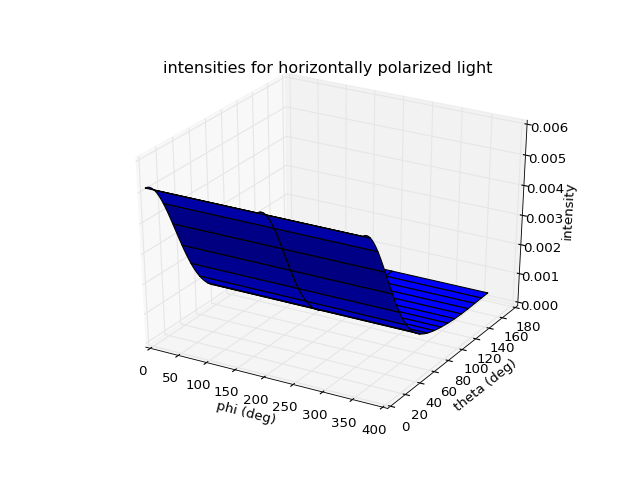

In [3]:
theta = np.linspace(0, 180, 181)
phi = np.linspace(0, 360, 20)
stokes_vec = np.array([1, 1, 0, 0])

# calculate the intensities
calculation = mstm.MSTMCalculation(target, wavelength, theta, phi)
result = calculation.run()
intensity = result.calc_intensity(stokes_vec)

# reshape the result to be a 2d array
table = intensity[0].pivot_table('intensity', 'theta', 'phi')

plt.figure()
ax = plt.axes(projection = '3d')
p,t=np.meshgrid(phi,theta)
ax.plot_surface(p,t,table.as_matrix())
ax.set_zlabel('intensity')
plt.xlabel('phi (deg)')
plt.ylabel('theta (deg)')
plt.title('intensities for horizontally polarized light')

### Now we calculuate the intensity as a function of theta and phi, but for vertically polarized incident light
The target has 1 sphere of radius 0.125 um, and the incident is horizontally polarized. The incident has 2pi/lamba = 15.7 ==> lambda = 0.4 um

<IPython.core.display.Javascript object>


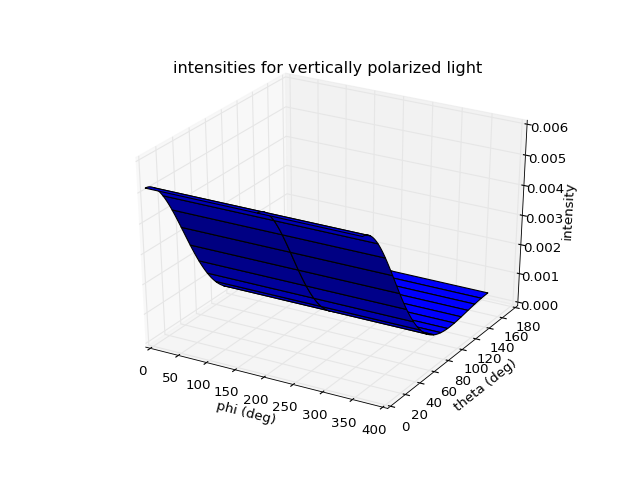

In [4]:
theta = np.linspace(0, 180, 181)
phi = np.linspace(0, 360, 20)
stokes_vec = np.array([1, -1, 0, 0])

# calculate the intensities
calculation = mstm.MSTMCalculation(target, wavelength, theta, phi)
result = calculation.run()
intensity = result.calc_intensity(stokes_vec)

# reshape the result to be a 2d array
table = intensity[0].pivot_table('intensity', 'theta', 'phi')

plt.figure()
ax = plt.axes(projection = '3d')
p,t=np.meshgrid(phi,theta)
ax.plot_surface(p,t,table.as_matrix())
ax.set_zlabel('intensity')
plt.xlabel('phi (deg)')
plt.ylabel('theta (deg)')
plt.title('intensities for vertically polarized light')

We can see that the intensity plots for the two polarizations appear similar in shape, but the peak is wider for the vertically polarized one. They also appear to have no dependence on phi except for a barely perceptible bump around phi = 50 degrees. This is not consistent with what we expect to see because:

1. we expect to see a dependence on phi
2. we expect that the intensities should not be identical for the two polarization, but only that their integrals should be identical

### Now let's look at the integrated Intensities as a function of wavelength

<IPython.core.display.Javascript object>


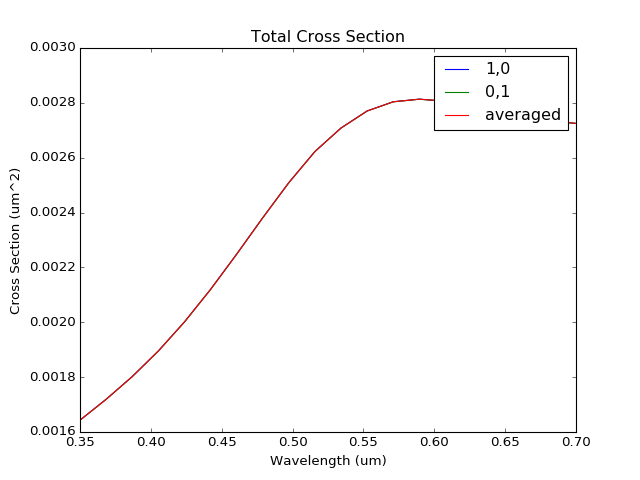

In [5]:
wavelength = 0.35, 0.7, 20

# calculate the cross section for horizontal polarization
calculation = mstm.MSTMCalculation(target, wavelength, theta, phi=None)
result = calculation.run()
total_csca_perp = result.calc_cross_section(np.array([1, 1, 0, 0]), 0., 180.)

# calculate the cross section for horizontal polarization
total_csca_par = result.calc_cross_section(np.array([1, -1, 0, 0]), 0., 180.)

plt.figure()
plt.plot(result.wavelength, total_csca_par)
plt.plot(result.wavelength, total_csca_perp)
plt.plot(result.wavelength, (total_csca_par+total_csca_perp)/2)
plt.legend(['1,0','0,1','averaged'])
plt.xlabel('Wavelength (um)')
plt.xlim([0.35,0.7])
plt.ylabel('Cross Section (um^2)')
plt.title('Total Cross Section')